In [1]:
import sys
sys.path.append("..") # This is for the imports from adjacent folders to work

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 200

from main_functions.DCv5_parallel_doubly_stretched import get_circuit as problem_circuit
#from main_functions.DCv5_multiple_XY4 import get_circuit as problem_circuit
from main_functions.gen_dynamic_circuit_v5 import get_circuit as test_circuit
from main_functions.solve_diagonal_ME import solve_diag_ME
from qiskit_aer import AerSimulator
from qiskit import generate_preset_pass_manager
from qiskit.circuit import IfElseOp
from qiskit_ibm_runtime import Batch, SamplerV2
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_ibm_runtime import QiskitRuntimeService

import os
import pickle
import json
import math
import random
from utils.get_circuit_properties import get_circuit_properties
from utils.isa_cdr import generate_isa_clifford_circuits, get_populations, train_model, correct_observable
from utils.get_worst_case_trotter_schedule import get_worst_case_trotter_schedule
from utils.generate_complementary_colors import generate_complementary_colors

In [2]:
QiskitRuntimeService.save_account( 
 token="ryeQLJCCBlp2Y1CK7B0KvXRUvVDG7Xbkhu8H2L9MXUsU", 
 channel="ibm_cloud",
 instance='crn:v1:bluemix:public:quantum-computing:us-east:a/5fef03c739244d07801bbb0cd3b5d388:4854b5b3-784b-48cc-8949-0fe8c86aa28b::', 
 name="quantum_credits",
 overwrite=True
 )

service = QiskitRuntimeService(name="quantum_credits")

In [3]:
num_emitters = 50
omega_m = [1.2]*num_emitters
omega_c = 1.1
gamma = [0.8*10**(-6)]*num_emitters
kappa = [0.2]
g = [0.03]*(2*(num_emitters-1)) 
t = 200*(np.linspace(0, 1, 5)**1.5)

#initial_state = [str(i) for i in random.sample(range(50), 35)]
# print(initial_state)
initial_state = ['39', '48', '43', '28', '2', '12', '37', '8', '17', '14', '40', '26', '22', '46', '18', '38', '25', '23', '4', '49', '20', '7', '33', '13', '31', '32', '6', '21', '11', '34', '3', '45', '44', '0', '15']
# initial_state = ['1']
samples = 10**2
noisy_backend = service.backend("ibm_kingston")
optimization_level = 2
shots = 4*(0.5*10**4)
options = {"default_shots": shots}

In [7]:
k = 3
stored_cliff = []

qc, init_layout = problem_circuit(num_emitters, omega_m, omega_c, g, gamma, kappa, initial_state, k, noisy_backend)
pm = generate_preset_pass_manager(optimization_level, target=noisy_backend.target, initial_layout = init_layout, routing_method = 'none')
isa_qc = pm.run(qc)
pubs = [(isa_qc, x) for x in t]

for x in t:
    clifford_circuits = generate_isa_clifford_circuits(isa_qc, random_init = False, bias = 'inverse', bias_parameter = None, param_value = x, num_variants = samples)
    stored_cliff.append(clifford_circuits)

filename = r"C:\Users\Benjamin\iCloudDrive\PhD\Projects\Efficient modeling of dissipative dynamics using quantum circuits\Data\[CCs]50_emitters_3_trotter.pkl.json"
with open(filename, "wb") as f:
    pickle.dump(stored_cliff, f)

In [8]:
filename = r"C:\Users\Benjamin\iCloudDrive\PhD\Projects\Efficient modeling of dissipative dynamics using quantum circuits\Data\[CCs]50_emitters_3_trotter.pkl.json"
with open(filename, "rb") as f:
    stored_cliff = pickle.load(f)

batch = Batch(backend = noisy_backend, max_time = '3h')
sampler = SamplerV2(mode = batch, options = options)

max_circuits = 1 

main_job_ids = []
cliff_job_ids = []
for idx, instant in enumerate(t):
    main_job = sampler.run([pubs[idx]])
    main_job_ids.append(main_job.job_id())
    print(f'Main job {idx}/{len(t) - 1} submitted with id: {main_job.job_id()}')

    for i in range(0, samples, max_circuits):
        if i + max_circuits <= samples:
            cliff_job = sampler.run(stored_cliff[idx][i : i + max_circuits]) 
        else:
            cliff_job = sampler.run(stored_cliff[idx][i : samples])
        cliff_job_ids.append(cliff_job.job_id())
    
batch.close()

with open(f"[MJIDs]50_emitters_{k}_trotter.json", "w") as f:
    json.dump(main_job_ids, f)
with open(f"[CJIDs]50_emitters_{k}_trotter.json", "w") as f:
    json.dump(cliff_job_ids, f)

Main job 0/4 submitted with id: d44bbu90f7bc73897cc0
Main job 1/4 submitted with id: d44bdc5o35ts73c8i3cg
Main job 2/4 submitted with id: d44bep10f7bc73897fo0
Main job 3/4 submitted with id: d44bg6lo35ts73c8i6tg
Main job 4/4 submitted with id: d44bhido35ts73c8i8g0


In [28]:
with open("../datasets/[MJIDs]50_emitters_3_trotter.json", "r") as f:
    main_job_ids = json.load(f)
with open("../datasets/[CJIDs]50_emitters_3_trotter.json", "r") as f:
    cliff_job_ids = json.load(f)

# Retrieving raw results:
raw_data = { str(i) : [] for i in range(num_emitters) }
for (idx, job_id) in enumerate(main_job_ids):
    job = service.job(job_id)
    result = job.result()
    evs, std = get_populations(num_emitters, result)
    for key in raw_data.keys():
        raw_data[key].append(evs[key])
    print(f'Main job {idx+1}/{len(main_job_ids)} successfully post-processed!')

cliff_job_partitions = samples

# Retrieving Clifford jobs:
noisy_training_data = { str(i) : [] for i in range(num_emitters) }
for i in range(0, len(cliff_job_ids), cliff_job_partitions):
    sub_cliff_job_ids = cliff_job_ids[i : i + cliff_job_partitions]
    for (idx, job_id) in enumerate(sub_cliff_job_ids):
        job = service.job(job_id)
        if job.status() == 'ERROR':
            print(f'Job with ID {job_id} could not be processed')
            continue
        result = job.result()
        evs, std = get_populations(num_emitters, result)
        for key in noisy_training_data.keys():
            noisy_training_data[key].append(evs[key])
        print(f'Clifford Job {idx+1}/{len(sub_cliff_job_ids)} with ID:{job_id} successfully post-processed!')
    print(f'Clifford Batch {int(i/(cliff_job_partitions-1))+1}/{int(len(cliff_job_ids)/cliff_job_partitions)} completed!')

# Flattening the training data so that for each key (qubit) we have len(t) lists, each containing samples floats.
merged_data = {}
for key, sublists in noisy_training_data.items():
    merged = []
    for i in range(0, len(sublists), cliff_job_partitions):
        # flatten (concatenate) the next `cliff_job_partitions` sublists
        merged_group = [item for sublist in sublists[i:i + cliff_job_partitions] for item in sublist]
        merged.append(merged_group)
    merged_data[key] = merged

with open("../datasets/[RD]50_emitters_3_trotter.json", "w") as f:
    json.dump(raw_data, f)
with open("../datasets/[NTD]50_emitters_3_trotter.json", "w") as f:
    json.dump(merged_data, f)

Main job 1/5 successfully post-processed!
Main job 2/5 successfully post-processed!
Main job 3/5 successfully post-processed!
Main job 4/5 successfully post-processed!
Main job 5/5 successfully post-processed!
Clifford Job 1/100 with ID:d44bbv10f7bc73897ccg successfully post-processed!
Clifford Job 2/100 with ID:d44bbvhag40c7385lidg successfully post-processed!
Clifford Job 3/100 with ID:d44bc010f7bc73897cg0 successfully post-processed!
Clifford Job 4/100 with ID:d44bc09ag40c7385lif0 successfully post-processed!
Clifford Job 5/100 with ID:d44bc0to35ts73c8i1kg successfully post-processed!
Clifford Job 6/100 with ID:d44bc1do35ts73c8i1lg successfully post-processed!
Clifford Job 7/100 with ID:d44bc1o7i53s73e4tdhg successfully post-processed!
Clifford Job 8/100 with ID:d44bc29ag40c7385ligg successfully post-processed!
Clifford Job 9/100 with ID:d44bc2o7i53s73e4tdjg successfully post-processed!
Clifford Job 10/100 with ID:d44bc35o35ts73c8i1o0 successfully post-processed!
Clifford Job 11/100

In [8]:
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit import Delay

def remove_stretch(qc):
    dag = circuit_to_dag(qc)
    for node in dag.op_nodes():
        if isinstance(node.op, Delay):
            #print(node.op)
            dag.remove_op_node(node)
            
    return dag_to_circuit(dag)

In [9]:
filename = r"C:\Users\Benjamin\iCloudDrive\PhD\Projects\Efficient modeling of dissipative dynamics using quantum circuits\Data\[CCs]50_emitters_1_trotter.pkl"
with open(filename, "rb") as f:
    stored_cliff = pickle.load(f)

exact_sampler = AerSampler(options=dict(backend_options=dict(method="stabilizer"), run_options = dict(default_shots = shots)))
ideal_training_data = { str(i) : [] for i in range(num_emitters) }
for idx, instant in enumerate(t):
    clifford_circuits = stored_cliff[idx]
    clifford_circuits = [remove_stretch(x) for x in clifford_circuits] # Otherwise AerSimulator raises an error
    job = exact_sampler.run(clifford_circuits)
    result = job.result()
    i_t_d, std = get_populations(num_emitters, result)
    for key in ideal_training_data.keys():
        ideal_training_data[key].append(i_t_d[key])
    print(f'{idx+1}/{len(t)} done!')

with open("../datasets/[ITD]50_emitters_1_trotter.json", "w") as f:
    json.dump(ideal_training_data, f)   

1/5 done!
2/5 done!
3/5 done!
4/5 done!
5/5 done!


In [14]:
len(ideal_training_data['0'])

5

In [20]:
raw_data[key][0]

[0.4092500000000059]

In [72]:
with open("../datasets/[RD]50_emitters_3_trotter.json", "r") as f:
    raw_data = json.load(f)
with open("../datasets/[NTD]50_emitters_3_trotter.json", "r") as f:
    noisy_training_data = json.load(f)
with open("../datasets/[ITD]50_emitters_3_trotter.json", "r") as f:
    ideal_training_data = json.load(f) 

corrected_data = { str(i) : [] for i in range(num_emitters) }
errors = { str(i) : [] for i in range(num_emitters) }
for qubit in corrected_data.keys():
    data = []
    err = []
    print(f'Correcting qubit {(int(qubit))}')
    for idx, instant in enumerate(t):
        model, delta_a, delta_b, r2 = train_model(ideal_training_data[qubit][idx], noisy_training_data[qubit][idx])
        corrected, delta = correct_observable(raw_data[qubit][idx], model, delta_a, delta_b)
        data.append(corrected)
        err.append(delta)
        print(f'{idx}/{len(t)} done!')
    corrected_data[qubit] = data
    errors[qubit] = err

samples = len(ideal_training_data['0'][0])
instants = len(ideal_training_data['0'])
total_population = { 'mps' : [],
                    'raw data': [],
                    'ideal training data': [],
                    'noisy training data' : [],
                    'corrected' : [],
                    'error' : []}

for i in range(instants):
    acc = np.zeros(samples)
    for key in ideal_training_data.keys():
        acc += ideal_training_data[key][i]
    total_population['ideal training data'].append(acc)

    acc = np.zeros(samples)
    for key in noisy_training_data.keys():
        acc += noisy_training_data[key][i]
    total_population['noisy training data'].append(acc)

    acc = 0
    for key in raw_data.keys():
        acc += raw_data[key][i][0]
    total_population['raw data'].append(acc)

for idx, instant in enumerate(t):
    model, delta_a, delta_b, r2 = train_model(total_population['ideal training data'][idx], total_population['noisy training data'][idx])
    corrected, delta = correct_observable(total_population['raw data'][idx], model, delta_a, delta_b)
    total_population['corrected'].append(corrected)
    total_population['error'].append(delta)

Correcting qubit 0
Learned correction model: y = (-0.0061 ± 0.0546 )x + (0.5144 ± 0.0273)
$R^2$ score: 0.0001
0/5 done!
Learned correction model: y = (0.5548 ± 0.0222 )x + (0.2383 ± 0.0114)
$R^2$ score: 0.8645
1/5 done!
Learned correction model: y = (0.6332 ± 0.0199 )x + (0.2062 ± 0.0102)
$R^2$ score: 0.9115
2/5 done!
Learned correction model: y = (0.6862 ± 0.0140 )x + (0.1718 ± 0.0070)
$R^2$ score: 0.9607
3/5 done!
Learned correction model: y = (0.6840 ± 0.0125 )x + (0.1684 ± 0.0061)
$R^2$ score: 0.9682
4/5 done!
Correcting qubit 1
Learned correction model: y = (0.2481 ± 0.0168 )x + (0.3774 ± 0.0085)
$R^2$ score: 0.6900
0/5 done!
Learned correction model: y = (0.6183 ± 0.0249 )x + (0.1934 ± 0.0122)
$R^2$ score: 0.8627
1/5 done!
Learned correction model: y = (0.7082 ± 0.0156 )x + (0.1483 ± 0.0079)
$R^2$ score: 0.9545
2/5 done!
Learned correction model: y = (0.7087 ± 0.0172 )x + (0.1483 ± 0.0086)
$R^2$ score: 0.9457
3/5 done!
Learned correction model: y = (0.7397 ± 0.0126 )x + (0.1329 ±

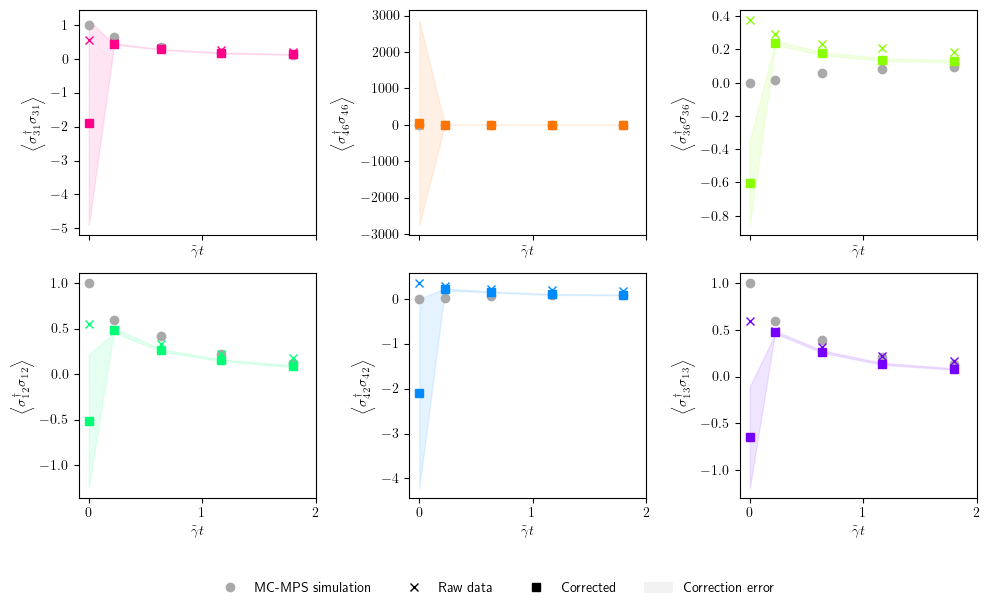

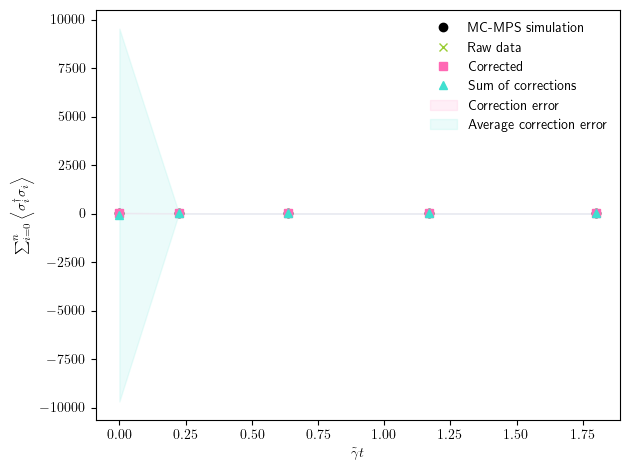

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
# plt.rcParams.update({'font.size': 15})

mps_data = np.load("../datasets/[MCMPS]50_emitters_3_trotter.npz")

plot_qubits = random.sample(sorted(corrected_data.keys()), 6)
plot_qubits = ['31', '46', '36', '12', '42', '13']
colors = generate_complementary_colors(len(plot_qubits), 'neon', 'deeppink')
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)

axes = axes.flatten()  

# Plot each qubit
for i, qubit in enumerate(plot_qubits):
    ax = axes[i]
    color = colors[i]

    ax.plot(0.009*t, mps_data[qubit], linestyle='none', marker='o', color='darkgrey')
    ax.plot(0.009*t, raw_data[qubit], linestyle='none', marker='x', color=color)
    ax.plot(0.009*t, corrected_data[qubit], linestyle='none', marker='s', color=color)
    ax.plot(np.nan, np.nan, linestyle='solid', color=color)
    
    upper_bound = np.array(corrected_data[qubit]) + np.array(errors[qubit])
    lower_bound = np.array(corrected_data[qubit]) - np.array(errors[qubit])
    ax.fill_between(0.009*np.array(t), lower_bound.ravel(), upper_bound.ravel(), color=color, alpha=0.1)
    ax.set_ylabel(f'$\\left< \\sigma^{{\\dagger}}_{{{int(qubit)}}} \\sigma_{{{int(qubit)}}} \\right>$')
    ax.set_xlabel('$\\tilde{\\gamma} t$')
    ax.set_xticks([0, 1, 2])
    # ax.grid(True, alpha=0.3)

# Shared x label
# fig.text(0.5, 0.04, '$\\tilde{\\gamma} t$', ha='center')

handles = [
    plt.Line2D([], [], linestyle='none', marker='o', color='darkgrey', label='MC-MPS simulation'),
    plt.Line2D([], [], linestyle='none', marker='x', color='black', label='Raw data'),
    plt.Line2D([], [], linestyle='none', marker='s', color='black', label='Corrected'),
    mpatches.Rectangle((0, 0), 1, 1, 
                                facecolor='grey', 
                                alpha=0.1, 
                                edgecolor='darkgrey', # Optional: adds a slight border
                                linewidth=0.5)
]

labels = ['MC-MPS simulation', 'Raw data', 'Corrected', 'Correction error']

fig.legend(handles=handles, labels = labels, loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig('../figs/50_emitters_populations_3_trotter.png', bbox_inches='tight', transparent = True)
plt.show()

for i in range(instants):
    acc = 0
    for key in mps_data.keys():
        acc += mps_data[key][i]
    total_population['mps'].append(acc)

total_corrected = []
average_error_corrected = []
for i in range(instants):
    acc = 0
    error_acc = 0
    for key in corrected_data.keys():
        acc += corrected_data[key][i]
        error_acc += errors[key][i]
    total_corrected.append(acc)
    average_error_corrected.append(error_acc/num_emitters)

fig, axes = plt.subplots()
axes.plot(0.009*t, total_population['mps'], linestyle='none', marker='o', color='black', label = 'MC-MPS simulation')
axes.plot(0.009*t, total_population['raw data'], linestyle='none', marker='x', color='yellowgreen', label = 'Raw data')
axes.plot(0.009*t, total_population['corrected'], linestyle='none', marker='s', color='hotpink', label = 'Corrected')
axes.plot(0.009*t, total_corrected, linestyle='none', marker='^', color='turquoise', label = 'Sum of corrections')
axes.plot(np.nan, np.nan, linestyle='solid', color=color)

upper_bound = np.array(total_population['corrected']) + np.array(total_population['error'])
lower_bound = np.array(total_population['corrected']) - np.array(total_population['error'])
axes.fill_between(0.009*np.array(t), lower_bound.ravel(), upper_bound.ravel(), color='hotpink', alpha=0.1, label = 'Correction error')

upper_bound = np.array(total_corrected) + np.array(average_error_corrected)
lower_bound = np.array(total_corrected) - np.array(average_error_corrected)
axes.fill_between(0.009*np.array(t), lower_bound.ravel(), upper_bound.ravel(), color='turquoise', alpha=0.1, label = 'Average correction error')

axes.set_ylabel(f'$\\sum_{{i=0}}^{{n}}\\left< \\sigma^{{\\dagger}}_{{i}} \\sigma_{{i}} \\right>$')
axes.set_xlabel('$\\tilde{\\gamma} t$')
plt.legend(frameon = False)

plt.tight_layout()
plt.savefig('../figs/50_emitters_total_population_k_3.png', bbox_inches='tight', transparent = True)
plt.show()